# PCA Analysis of Poses

This notebook combines PCA visualization and analysis of pose data to understand:
1. The structure of principal components in pose space
2. Which principal components are most important for predicting position

The analysis is divided into two main sections:
- **Section 1**: Visualizing Principal Components
- **Section 2**: Identifying Important Principal Components for Position Prediction

## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import torch
import yaml

In [4]:
os.chdir(Path().resolve().parent)

## Data Loading and Configuration

Let's start by loading the model configuration and setting up consistent data across all sections.

In [267]:
old_gbyk = True
prefix = "old_" if old_gbyk else ""
run = "20250807145637" if old_gbyk else "20250807155259"

config_path = f"artifacts/config/poses_to_position/{run}.yml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [268]:
test_intervals, train_intervals, _ = ml.intervals.load_all_by_tiers(
    data_dir=config["data_dir"],
    sessions=config["sessions"],
    experiment=config["experiment"],
    include_trial=config["intervals"]["include_trial"],
    include_homing=config["intervals"]["include_homing"],
    include_sitting=config["intervals"]["include_sitting"],
    balance_intervals=config["intervals"]["balance_intervals"],
    sampling_rate=config["sampling_rate"],
)

<string>:24: RuntimeWarning:

Mean of empty slice



In [269]:
data_dict = ml.data.load_all(
    data_dir=config["data_dir"],
    sessions=config["sessions"],
    in_modalities=config["in_modalities"],
    out_modalities=config["out_modalities"],
    experiment=config["experiment"],
    poses_config=config["poses"],
    position_config=config["position"],
    kinematics_config=config["kinematics"],
    spikes_config=config["spikes"],
    train_intervals=train_intervals,
)

<string>:24: RuntimeWarning:

Mean of empty slice

<string>:24: RuntimeWarning:

Mean of empty slice

<string>:24: RuntimeWarning:

Mean of empty slice



In [133]:
# Select a single session for PCA visualization (use first session)
viz_session = config["sessions"][0]
print(f"Using session '{viz_session}' for PCA visualization")

# I need to load this separately because the poses in the data_dict were already projected to the PCA space.
poses_for_pca = ml.data.load_poses(
    data_dir=Path(config["data_dir"]),
    session=viz_session,
    experiment=config["experiment"],
    poses_config={"representation": "egocentric"},
)
print(f"Poses shape for PCA: {poses_for_pca.shape}")

Using session 'bex_20230621_spikes_sorted_SES' for PCA visualization
Poses shape for PCA: (162731, 63)


In [134]:
# Perform PCA on the poses data (using training intervals)
poses_projected, pca = ml.utils.project_to_pca(
    poses_for_pca, train_intervals[viz_session]
)

print(f"PCA fitted with {pca.n_components_} components")
print(f"Projected poses shape: {poses_projected.shape}")

PCA fitted with 63 components
Projected poses shape: (162731, 63)


## Section 1: Visualizing Principal Components

Now let's visualize the principal components to understand the main modes of variation in the pose data.

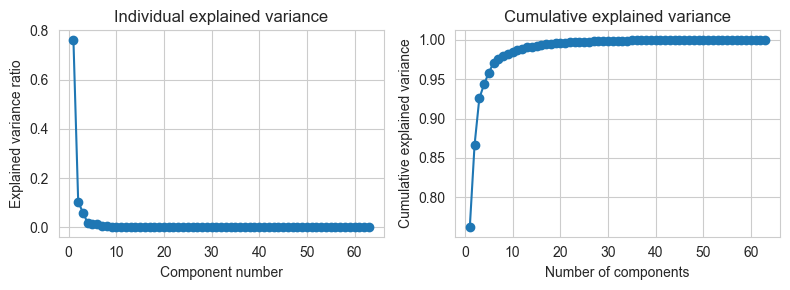

First 10 components explain 0.985 of total variance
First 20 components explain 0.996 of total variance


In [135]:
explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.xlabel("Component number")
plt.ylabel("Explained variance ratio")
plt.title("Individual explained variance")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained) + 1), cum_explained, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance")

plt.tight_layout()
plt.show()

print(f"First 10 components explain {cum_explained[9]:.3f} of total variance")
print(f"First 20 components explain {cum_explained[19]:.3f} of total variance")

In [136]:
component = 0  # Change this to visualize different components
n_keypoints = 21

print(
    f"Visualizing PC {component + 1} (explains {explained[component]:.3f} of variance)"
)
pc = pca.components_[component]

ml.plot.poses3d_improved(
    pc,
    experiment="gbyk",
)

Visualizing PC 1 (explains 0.762 of variance)


## Section 2: Identifying Important Principal Components for Position Prediction

Now let's analyze which principal components are most relevant for predicting position using the same data and PCA that we computed above.

In [270]:
in_dim, out_dim = ml.model.compute_dimensions(
    data_dict=data_dict,
    in_modalities=config["in_modalities"],
    out_modalities=config["out_modalities"],
    sessions=config["sessions"],
)
config["model"]["in_dim"] = in_dim
config["model"]["out_dim"] = out_dim

checkpoint_metadata = ml.model.load_checkpoint_metadata(
    uid=config["uid"],
    checkpoint_dir=config["checkpoint_dir"],
)

model = ml.model.load_model(
    architecture=config["model"]["architecture"],
    sessions=config["sessions"],
    readout_map=config["model"]["readout_map"],
    model_dict=config["model"],
    checkpoint_data=checkpoint_metadata,
)

In [271]:
print("Calculating baseline model performance...")

baseline = dict()

for session, data in data_dict.items():
    X = {"poses": torch.tensor(data["poses"], device=ml.utils.DEVICE)}
    y = data["position"]

    pred = model(X, session)
    pred = pred["position"].detach().cpu().numpy()
    mse_intervals = [
        np.mean((pred[s:e] - y[s:e]) ** 2) for s, e in test_intervals[session]
    ]
    baseline[session] = np.mean(mse_intervals).item()
    print(f"Baseline MSE for {session}: {baseline[session]:.4f}")

print(f"Average baseline MSE: {np.mean(list(baseline.values())):.4f}")

Calculating baseline model performance...
Baseline MSE for bex_20230623_denoised: 0.0473
Baseline MSE for ken_20230614_denoised: 0.0335
Baseline MSE for ken_20230618_denoised: 0.0124
Average baseline MSE: 0.0311


In [272]:
torch.manual_seed(0)
pcs_importance = dict()

for session, data in data_dict.items():
    print(f"Session: {session}")

    X = {"poses": torch.tensor(data["poses"], device=ml.utils.DEVICE)}
    y = data["position"]

    n_pcs = X["poses"].shape[-1]
    n_permutations = 10
    pc_mses = []

    for pc in range(n_pcs):
        if pc % 10 == 0:
            print(f"Processing PC {pc}")

        mse_intervals = []
        for start, end in test_intervals[session]:
            n_samples = end - start
            perm_indices = start + torch.stack(
                [
                    torch.randperm(n_samples, device=ml.utils.DEVICE)
                    for _ in range(n_permutations)
                ]
            )

            original_pc = X["poses"][start:end, pc].clone()
            perm_mses = []
            with torch.no_grad():
                for perm_idx in perm_indices:
                    X["poses"][start:end, pc] = original_pc[perm_idx]
                    pred = (
                        model({"poses": X["poses"][start:end]}, session)[
                            "position"
                        ]
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    perm_mses.append(np.mean((pred - y[start:end]) ** 2))

            mse_intervals.append(np.mean(perm_mses))
            X["poses"][start:end, pc] = original_pc

        pc_mses.append(np.mean(mse_intervals))

    pcs_importance[session] = pc_mses

Session: bex_20230623_denoised
Processing PC 0
Processing PC 10
Processing PC 20
Processing PC 30
Processing PC 40
Processing PC 50
Processing PC 60
Session: ken_20230614_denoised
Processing PC 0
Processing PC 10
Processing PC 20
Processing PC 30
Processing PC 40
Processing PC 50
Processing PC 60
Session: ken_20230618_denoised
Processing PC 0
Processing PC 10
Processing PC 20
Processing PC 30
Processing PC 40
Processing PC 50
Processing PC 60


In [273]:
results_dict = {
    "session": [],
    "mse": [],
    "pc": [],
    "importance": [],
}

for session, mses in pcs_importance.items():
    session_baseline = baseline[session]
    for pc_idx, mse in enumerate(mses):
        importance = mse - session_baseline
        results_dict["session"].append(session)
        results_dict["mse"].append(mse)
        results_dict["pc"].append(pc_idx)
        results_dict["importance"].append(importance)

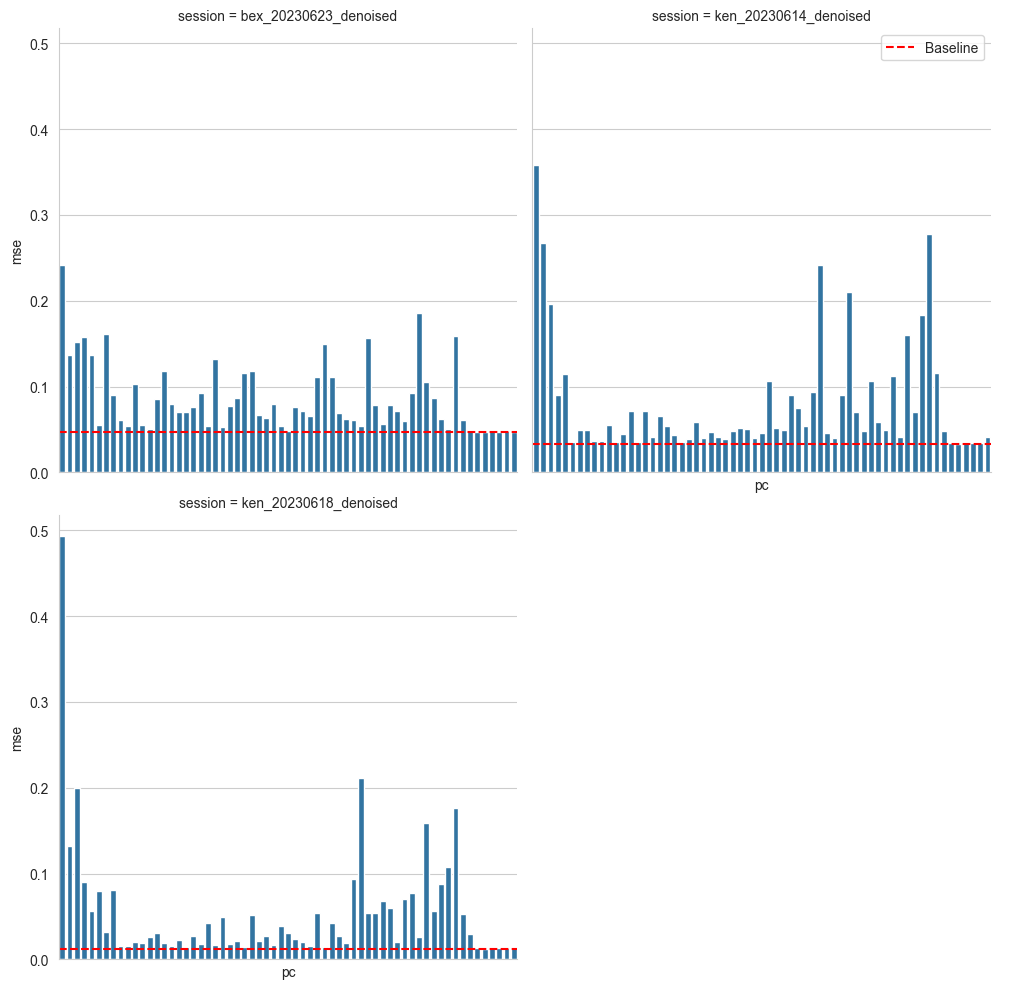

In [276]:
sns.set_style("whitegrid")

g = sns.catplot(
    data=results_dict, x="pc", y="mse", col="session", col_wrap=2, kind="bar"
)

for ax in g.axes.flatten():
    title = ax.get_title()
    session = title.split(" = ")[-1]
    ax.axhline(
        y=baseline[session], color="red", linestyle="--", label="Baseline"
    )

g.axes.flatten()[1].legend(loc="upper right")
g.set(xticks=[])
plt.tight_layout()
plt.savefig(
    f"artifacts/plots/analysis_pca/{prefix}barplot_mse_pcs_baseline.svg",
    bbox_inches="tight",
)
plt.show()

In [277]:
importance_thresholds = {
    0.15: f"{prefix}loose",
    0.10: f"{prefix}medium",
    0.05: f"{prefix}strict",
    0.01: f"{prefix}draconian",
}

pcs_to_exclude = dict()
important_pcs = dict()

print("Summary of Principal Component Importance Analysis")

for importance_threshold, threshold_name in importance_thresholds.items():
    print(f"\nUsing importance threshold: {importance_threshold:.2f}")
    print("-" * 79)
    for session, mses in pcs_importance.items():
        mses = np.array(mses)
        session_baseline = baseline[session]

        important_indices = np.where(
            mses >= importance_threshold + session_baseline
        )[0]

        exclude_indices = np.where(
            mses < importance_threshold + session_baseline
        )[0]

        pcs_to_exclude[session] = exclude_indices.tolist()
        important_pcs[session] = important_indices.tolist()

        print(f"Session: {session}")
        print(f"Baseline MSE: {session_baseline:.4f}")
        print(
            f"Important PCs (n={len(important_indices)}): {important_indices.tolist()}"
        )
        print(
            f"PCs that could be excluded (n={len(exclude_indices)}): {exclude_indices.tolist()}"
        )
        print("=" * 79)

    with open(f"artifacts/tables/analysis_pca/{threshold_name}.yml", "w") as f:
        yaml.safe_dump(important_pcs, f)

Summary of Principal Component Importance Analysis

Using importance threshold: 0.15
-------------------------------------------------------------------------------
Session: bex_20230623_denoised
Baseline MSE: 0.0473
Important PCs (n=1): [0]
PCs that could be excluded (n=62): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Session: ken_20230614_denoised
Baseline MSE: 0.0335
Important PCs (n=7): [0, 1, 2, 39, 43, 53, 54]
PCs that could be excluded (n=56): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62]
Session: ken_20230618_denoised
Baseline MSE: 0.0124
Important PCs (n=4): [0, 2, 41, 54]
PCs that could be excluded (n=59): [1, 3, 4

## Section 3: Connecting PCA Structure with Importance

Now let's visualize the most important principal components identified in our analysis to understand what pose patterns are critical for position prediction.

In [17]:
important_pc_indices = important_pcs[viz_session]
print(f"Visualizing important PCs for session: {viz_session}")
print(f"Important PC indices: {important_pc_indices}")

for i, pc_idx in enumerate(important_pc_indices[:3]):
    if pc_idx < len(explained):
        print(f"PC {pc_idx + 1} (explains {explained[pc_idx]:.3f} of variance)")
        pc = pca.components_[pc_idx]
        ml.plot.poses3d_improved(
            pc,
            experiment="gbyk",
            show_joints=True,
        )

Visualizing important PCs for session: bex_20230621_spikes_sorted_SES
Important PC indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 45, 46, 47, 49]
PC 1 (explains 0.715 of variance)


PC 2 (explains 0.111 of variance)


PC 3 (explains 0.074 of variance)


## Summary: Connecting PCA Structure with Importance

Let's create a final summary that connects the PCA structure with the importance analysis.

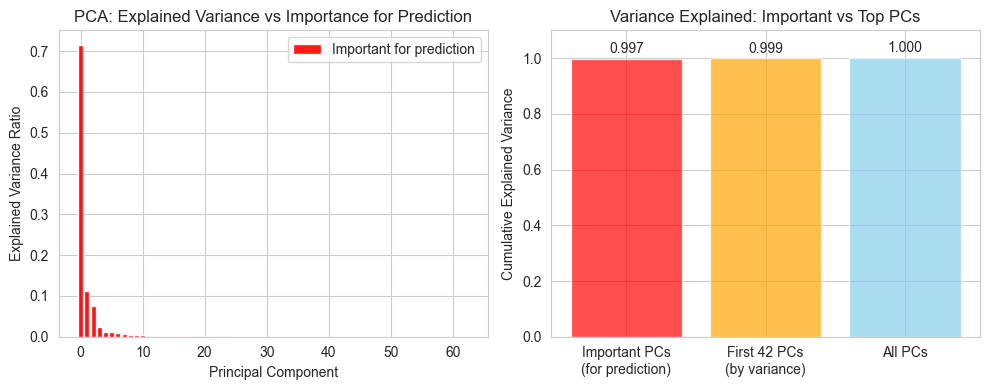

Analysis Summary:
Session analyzed: bex_20230621_spikes_sorted_SES
Total PCs: 63
Important PCs for prediction: 42
Variance explained by important PCs: 0.997
Variance explained by first 42 PCs: 0.999
Most important PC: 1 (explains 0.715)
Important PC indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 45, 46, 47, 49]


In [ ]:
if len(important_pcs) > 0 and len(important_pcs[viz_session]) > 0:
    # Create a summary plot comparing explained variance vs importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Left plot: Explained variance by PC
    ax1.bar(range(len(explained)), explained, alpha=0.7, color="skyblue")

    # Highlight important PCs
    important_indices = important_pcs[viz_session]
    if len(important_indices) > 0:
        ax1.bar(
            [i for i in important_indices if i < len(explained)],
            [explained[i] for i in important_indices if i < len(explained)],
            alpha=0.9,
            color="red",
            label="Important for prediction",
        )

    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Explained Variance Ratio")
    ax1.set_title("PCA: Explained Variance vs Importance for Prediction")
    ax1.legend()

    # Right plot: Summary statistics
    total_var_important = sum(
        explained[i] for i in important_indices if i < len(explained)
    )
    total_var_first_n = (
        sum(explained[: len(important_indices)])
        if len(important_indices) > 0
        else 0
    )

    categories = [
        "Important PCs\n(for prediction)",
        f"First {len(important_indices)} PCs\n(by variance)",
        "All PCs",
    ]
    values = [total_var_important, total_var_first_n, 1.0]
    colors = ["red", "orange", "skyblue"]

    bars = ax2.bar(categories, values, color=colors, alpha=0.7)
    ax2.set_ylabel("Cumulative Explained Variance")
    ax2.set_title("Variance Explained: Important vs Top PCs")
    ax2.set_ylim(0, 1.1)

    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    print("Analysis Summary:")
    print("=" * 50)
    print(f"Session analyzed: {viz_session}")
    print(f"Total PCs: {len(explained)}")
    print(f"Important PCs for prediction: {len(important_indices)}")
    print(f"Variance explained by important PCs: {total_var_important:.3f}")
    print(
        f"Variance explained by first {len(important_indices)} PCs: {total_var_first_n:.3f}"
    )

    if len(important_indices) > 0:
        print(
            f"Most important PC: {important_indices[0] + 1} (explains {explained[important_indices[0]]:.3f})"
        )
        print(f"Important PC indices: {[i for i in important_indices]}")
else:
    print(
        "No important PCs found to summarize. Consider adjusting the importance threshold."
    )